# ML Pipeline

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,TimeSeriesSplit,KFold
# import Pipeline
from sklearn.pipeline import Pipeline
#  import onehotencoder
from sklearn.preprocessing import OneHotEncoder
# import StandardScaler
from sklearn.preprocessing import StandardScaler
# import MultiOutputRegressor
from sklearn.multioutput import MultiOutputRegressor
# import DummyRegressor
from sklearn.dummy import DummyRegressor
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras
import h5py
import requests
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Data

In [2]:
df = pd.read_csv("MontpellierAgentDeltaTimePTRVP.csv",sep=",",parse_dates=["date"])
# Only keep the data where agent_group is Vie Quotidienne,Pré-accueil, PrestO
df = df[df["agent_group"].isin(["Vie Quotidienne","Pré-accueil","PrestO"])]
df = df[df['date'] > "2020-07-01"]
df

,date,agent_group,Tmoy,PT,RVP
200,2020-07-02,Vie Quotidienne,408.960059,307,136
201,2020-07-03,Vie Quotidienne,318.790187,251,142
202,2020-07-03,Pré-accueil,214.607145,69,142
203,2020-07-06,Pré-accueil,276.586759,87,104
204,2020-07-06,Vie Quotidienne,263.972544,215,104
...,...,...,...,...,...
2703,2023-12-27,PrestO,456.337625,24,17
2705,2023-12-28,Vie Quotidienne,468.479631,157,19
2707,2023-12-28,PrestO,228.822087,46,19
2709,2023-12-29,Vie Quotidienne,406.818697,188,26


In [3]:
# Pivot the data to get Tmoy for each agent group on each date
pivot_tmoy = df.pivot(index='date', columns='agent_group', values='Tmoy').reset_index()

# Since PT and RVP are unique to each agent_group and date, let's create separate dataframes for them and merge everything together
pivot_pt = df.pivot(index='date', columns='agent_group', values='PT').reset_index()
pivot_rvp = df.pivot(index='date', columns='agent_group', values='RVP').reset_index()

# Merging PT and RVP pivoted data with the Tmoy pivoted data
result = pivot_tmoy.merge(pivot_pt, on='date', suffixes=('_Tmoy', '_PT'))
result = result.merge(pivot_rvp, on='date')

# Renaming columns for clarity
result.columns = [col.replace('_x', '_Tmoy').replace('_y', '_RVP') for col in result.columns]

result
df = result

## Create the features

In [4]:
def preprocessor(df):
    df = df.copy()
    df.loc[:, "year"] = df["date"].dt.year
    df.loc[:, 'n_day'] = df['date'].dt.dayofyear
    df.loc[:, 'n_week'] = df['date'].dt.isocalendar().week
    df.loc[:, 'n_month'] = df['date'].dt.month
    df.loc[:, 'n_day_week'] = df['date'].dt.dayofweek
    df.loc[:, 'n_day_month'] = df['date'].dt.day
    
    
    df = df.drop(columns=["date"])
    df = df.reset_index(drop=True)
    return df

from sklearn.preprocessing import FunctionTransformer
preprocess_transformer = FunctionTransformer(preprocessor)
preprocess_transformer

FunctionTransformer(func=<function preprocessor at 0x0000023126F24F70>)

## Create the WeekPipeline

In [6]:
class WeekPipeline():
    def __init__(self, model):
        self.model = Pipeline([
            ('standard', StandardScaler()),
            ('model', model)
        ])
        self.preprocessor = preprocess_transformer
    def split_data(self,df,target_names):
        for target_name in target_names:
            df = df[df[target_name] > 0].copy()
            df.loc[:, "lag7"] = df[target_name].shift(7)
            PT = target_name.split("_")[0]+"_PT"
            df.loc[:, PT+"lag7"] = df[PT].shift(7)

        X, y = (df.drop(columns=target_names),df[target_names])
        y = y.reset_index(drop=True)
        return X, y
    def fit_and_predict(self, X_train, y_train, X_test, y_test):
        X_test = self.preprocessor.transform(X_test)
        X_train = self.preprocessor.transform(X_train)
        y_pred = []
        # Split the data in 7 days groups
        for i in range(0, len(X_test), 7):
            X_week = X_test.iloc[i:i+7]
            y_week = y_test.iloc[i:i+7]
            
            self.model.fit(X_train, y_train)
            test_preds = self.model.predict(X_week)
            X_train = pd.concat([X_train, X_week])
            y_train = pd.concat([y_train, y_week])
            y_pred.extend(test_preds)
        return y_pred
    def score(self, y_test,y_pred):
        return np.sqrt(mean_squared_error(y_test, y_pred))
    
    def cross_val_plot(self, X, y, cv=5):
        kf = TimeSeriesSplit(n_splits=cv)
        scores = []
        i = 0
        # Initialise the subplot function using number of rows and columns 
        figure, axis = plt.subplots(cv, 1,figsize=(10, 12)) 
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # reset index
            X_test = X_test.reset_index(drop=True)
            y_test = y_test.reset_index(drop=True)
            y_pred = self.fit_and_predict(X_train, y_train, X_test, y_test)
            X_period = pd.concat([X_train, X_test])
            y_period = pd.concat([y_train, y_test])
            
            axis[i].plot(X_period['date'],y_period,label='Actual')
            axis[i].plot(X_test['date'],y_pred,label='Predicted')
            # change X scale 
            axis[i].set_xlim(X['date'].min(),X['date'].max())
            i+=1
        plt.show()
    def plot_pred(self,y_test, y_pred):
        # use matplotlib to plot the actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        

In [8]:
# convert an array of values into a dataset matrix
def create_dataset_lstm(dataset, look_back=7, forecast_horizon=7):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-forecast_horizon+1,forecast_horizon):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[(i+look_back):(i+look_back+forecast_horizon), 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [9]:
hyperparameter_grids = {
    'LSTM' : {
        'n_unit_per_layer': [20,30],
        'epochs': [10,15,20],
    },
    'LinearRegression': {
        'fit_intercept': [True, False],
    },
    'DecisionTreeRegressor': {
        'max_depth': [10, 20], 
        'min_samples_split': [2], 
    },
    'RandomForestRegressor': {
        # 'n_estimators': [10, 50, 100], 
        'n_estimators': [50], 
        'max_depth': [10],
    },
    'KNeighborsRegressor': {
        'n_neighbors': [10],  
        'algorithm': ['auto', 'ball_tree',],
    },
    'DummyRegressor': {
        'strategy': ['mean', 'median'], 
    },
    'SVR': {
        # 'C': [0.1, 1, 10, 100],  
        'C': [0.1],  
        'kernel': ['linear', 'rbf'], 
    },
    'AdaBoostRegressor': {
        'n_estimators': [10, 50, 100], 
        'learning_rate': [0.01, 0.1],  
    },
    'BaggingRegressor': {
        'n_estimators': [10, 20, 50], 
        'max_samples': [0.5, 1.0],  
    },
    'ExtraTreesRegressor': {
        'n_estimators': [50, 100],  
        'max_depth': [10],
        # 'max_depth': [10, 20, 30],
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100],  
        'learning_rate': [0.01, 0.1, 0.2],  
    },
    "XGBRegressor": {
        'n_estimators': [50, 100],  
        'max_depth': [10, 20, 30],
    },
    'MultiOutputRegressor': {
        "default": ["no hyperparameters"]
    }
}


In [11]:
df

,date,PrestO_Tmoy,Pré-accueil_Tmoy,Vie Quotidienne_Tmoy,PrestO_PT,Pré-accueil_PT,Vie Quotidienne_PT,PrestO,Pré-accueil,Vie Quotidienne
0,2020-07-02,NaN,NaN,408.960059,NaN,NaN,307.0,NaN,NaN,136.0
1,2020-07-03,NaN,214.607145,318.790187,NaN,69.0,251.0,NaN,142.0,142.0
2,2020-07-06,NaN,276.586759,263.972544,NaN,87.0,215.0,NaN,104.0,104.0
3,2020-07-07,NaN,126.746722,300.374165,NaN,18.0,206.0,NaN,97.0,97.0
4,2020-07-08,NaN,130.823224,159.295000,NaN,49.0,200.0,NaN,67.0,67.0
...,...,...,...,...,...,...,...,...,...,...
875,2023-12-22,274.117022,NaN,469.265491,46.0,NaN,169.0,86.0,NaN,86.0
876,2023-12-26,229.593083,NaN,521.227732,24.0,NaN,138.0,25.0,NaN,25.0
877,2023-12-27,456.337625,NaN,481.927059,24.0,NaN,152.0,17.0,NaN,17.0
878,2023-12-28,228.822087,NaN,468.479631,46.0,NaN,157.0,19.0,NaN,19.0


RandomForestRegressor
RandomForestRegressor {'max_depth': 10, 'n_estimators': 50} [126.41329701749828, 405.45779500247073, 332.20026417266905, 240.42758645706456, 491.42443481626043, 417.54727537279075, 208.27679960337562, 257.1464357442433, 271.53531580061025, 264.4010485561418, 340.1451851951447, 446.0743151292036, 183.83978969391998, 360.1316389053169, 823.9115981090561] 344.5955186383844 Tps:10.608917951583862sec


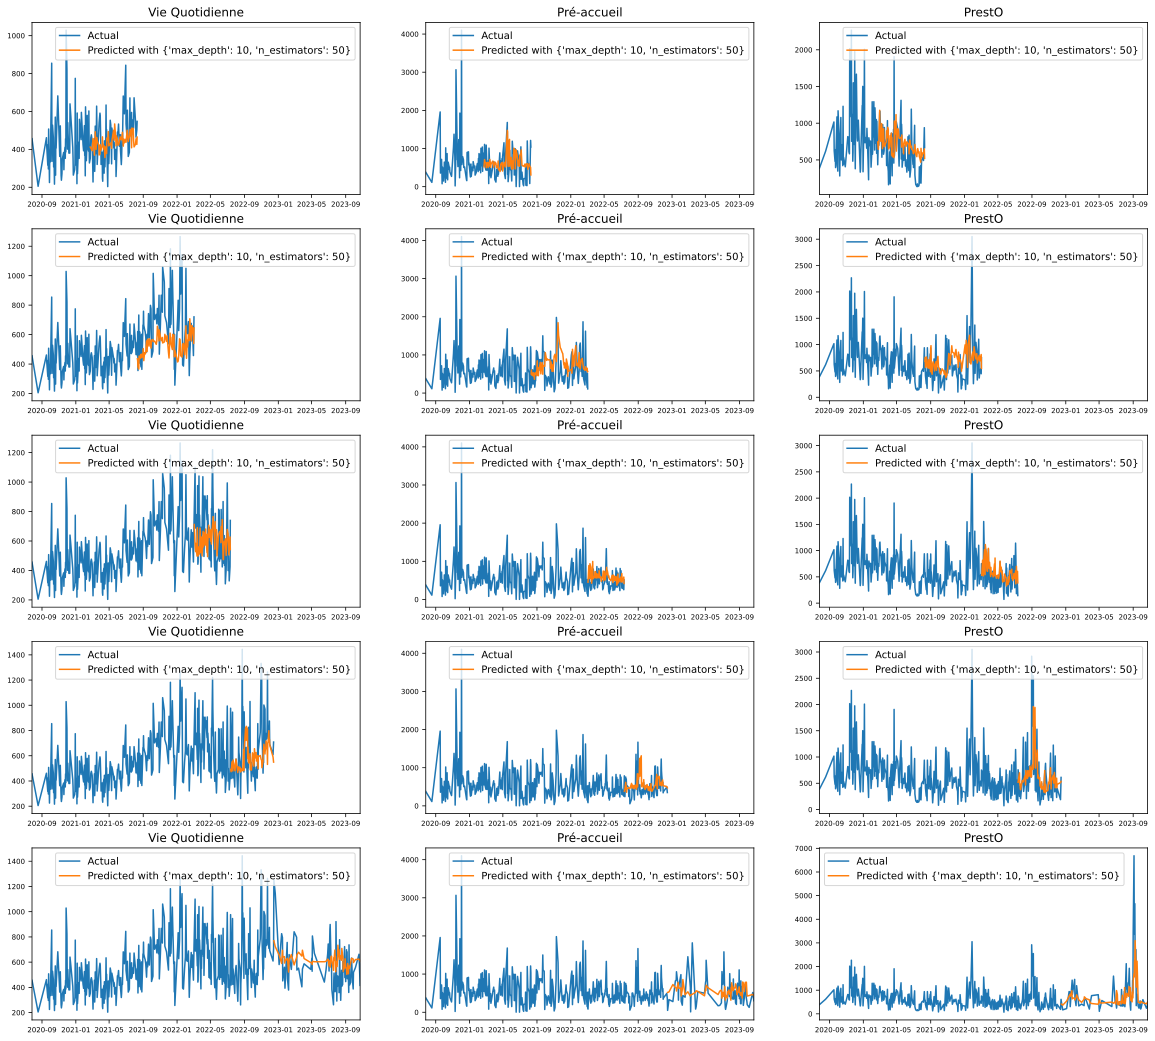

In [16]:
target_names = ["Vie Quotidienne_Tmoy","Pré-accueil_Tmoy","PrestO_Tmoy"]
agent_groups = ["Vie Quotidienne","Pré-accueil","PrestO"]
# LSTM model
look_back = 7
forecast_horizon = 7
models = [
    # MultiOutputRegressor(DummyRegressor()),
    # DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(n_jobs=-1, random_state=42),

]
# Example of integrating GridSearchCV with a specific model in a pipeline
cv = 5
for model in models:
    model_name = model.__class__.__name__ 
    print(model_name)  
    param_grid = hyperparameter_grids[model_name]

    figure, axis = plt.subplots(cv, 3,figsize=(20, 18))
    param_grid = ParameterGrid(param_grid)
    results = []
    plotActual = False
    for param_combination in param_grid:
        # chrono start
        time_start = time.time()
        hyperparameters = param_combination
        value = hyperparameters.get('default')
        if value != 'no hyperparameters':
            model.set_params(**hyperparameters)
        pipeline = WeekPipeline(model)
        # print model name
        X,y = pipeline.split_data(df,target_names)
        kf = TimeSeriesSplit(n_splits=cv)
        scores = []
        i = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # reset index
            X_test = X_test.reset_index(drop=True)
            y_test = y_test.reset_index(drop=True)
            y_pred = pipeline.fit_and_predict(X_train, y_train, X_test, y_test)
            for j in range(len(target_names)):
                scores.append(np.sqrt(mean_squared_error(y_test.iloc[:,j], [item[j] for item in y_pred])))
            X_period = pd.concat([X_train, X_test])   
            y_train_series = pd.DataFrame(y_train)
            y_test_series = pd.DataFrame(y_test)
            y_period = pd.concat([y_train_series, y_test_series])
            dates = X_period['date'].values[-len(y_period):]
            

            # Let's plot it on three different figures, one for each target_name
            for j in range(len(target_names)):
                y_plot = [item[j] for item in y_pred]
                axis[i][j].plot(dates, y_period.iloc[:,j], label='Actual')
                axis[i][j].plot(X_test['date'], y_plot, label='Predicted with '+str(hyperparameters))
                axis[i][j].set_xlim(X['date'].min(),X['date'].max())
                axis[i][j].legend()
                # set font of text to 6
                for item in ([axis[i][j].title, axis[i][j].xaxis.label, axis[i][j].yaxis.label] +
                    axis[i][j].get_xticklabels() + axis[i][j].get_yticklabels()):
                    item.set_fontsize(7)
                axis[i][j].set_title(agent_groups[j])
            i+=1
        # set title to the figure
        # figure.suptitle(model_name)
        results.append((model_name,hyperparameters,scores,np.mean(scores),"Tps:"+str(time.time()-time_start)+"sec"))
        plotActual = True
    results.sort(key=itemgetter(3))
    print(results[0][0],results[0][1],results[0][2],results[0][3],results[0][4])

# print for each model the best hyperparameters and results

plt.show()